# Data Project 3: Many Body Problem
In this data project, we will be exploring the long-term dynamical stability of satellites in a three-body system, with the *Jupiter trojans* as our test case. To do this, we will run some simple numerical simulations that evolve the positions and velocities of gravitationally interacting objects for three bodies orbiting in one plane (i.e. restricted to two dimensions). The code advances each particle according to its equation of motion, integrating it's future positions and velocities using a Runge-Kutta scheme.  


The code for initializing these simulations is below:

> run it once, but do not alter any of the code within the cell below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

class State:
    """ a container to hold a single star's position """

    def __init__(self, x, y, u, v):

        self.x = x
        self.y = y
        self.u = u
        self.v = v

    def __add__(self, other):
        return State(self.x + other.x, self.y + other.y,
                     self.u + other.u, self.v + other.v)

    def __sub__(self, other):
        return State(self.x - other.x, self.y - other.y,
                     self.u - other.u, self.v - other.v)

    def __mul__(self, other):
        return State(other * self.x, other * self.y,
                     other * self.u, other * self.v)

    def __rmul__(self, other):
        return self.__mul__(other)

    def __str__(self):
        return f"{self.x:10.6f} {self.y:10.6f}{self.u:10.6f} {self.v:10.6f}"


class ThreeBody:
    """ model the gravitational interaction of three stars """

    def __init__(self, d0,d1,d2, SMALL=1.e-30):
        """ pos is a tuple of x-y coords of the stars """

        self.G = 1  # dimensionless units

        self.bodies = [d0,d1,d2]

        star0 = State(d0['p0'][0], d0['p0'][1], d0['u0'][0], d0['u0'][1])
        star1 = State(d1['p0'][0], d1['p0'][1], d1['u0'][0], d1['u0'][1])
        star2 = State(d2['p0'][0], d2['p0'][1], d2['u0'][0], d2['u0'][1])

        # this history will be stored in a list of tuples, such that
        # stars[n][istar] is star istar and timestep n

        self.stars = [(star0, star1, star2)]

        self.M = np.array([d0['m'], d1['m'], d2['m']])

        self.SMALL = SMALL

        self.time = [0.0]

    def npts(self):
        """ return the number of integration points """
        return len(self.time)

    def center_of_mass(self, n):
        """return the center of mass of the system at time n"""

        Mtot = np.sum(self.M)

        x_cm = 0.0
        y_cm = 0.0


        for mass, star in zip(self.M, self.stars[n]):
            x_cm += mass * star.x
            y_cm += mass * star.y


        x_cm /= Mtot
        y_cm /= Mtot


        return x_cm, y_cm

    def energy(self, n):
        """return the energy of the system at time n """

        # kinetic energy
        KE = [0.5 * self.M[i] * (self.stars[n][i].u**2 +
                                 self.stars[n][i].v**2 )
              for i in range(len(self.M))]

        # potential energy -- we need all pairs, but order doesn't matter

        PE = [-self.G * self.M[i] * self.M[j] /
              np.sqrt((self.stars[n][i].x - self.stars[n][j].x)**2 +
                      (self.stars[n][i].y - self.stars[n][j].y)**2 )
              for i in range(len(self.M)) for j in range(len(self.M)) if i > j]

        return sum(KE) + sum(PE)

    def rhs(self, star_states):
        """ here, star states is (State, State, ...) """

        ydots = []

        for istar in range(len(self.M)):

            # compute the space derivatives

            dxdt = star_states[istar].u
            dydt = star_states[istar].v

            # compute the velocity derivatives
            dudt = 0.0
            dvdt = 0.0

            for jstar in range(len(self.M)):
                if istar == jstar:
                    continue
                else:
                    dx = star_states[jstar].x - star_states[istar].x
                    dy = star_states[jstar].y - star_states[istar].y

                    r = np.sqrt(dx**2 + dy**2 ) + self.SMALL

                    dudt += self.G * self.M[jstar] * dx / r**3
                    dvdt += self.G * self.M[jstar] * dy / r**3

            ydots.append(State(dxdt, dydt, dudt, dvdt))

        return ydots


    def single_step(self, state_old, dt):
        """ take a single RK-4 timestep from t to t+dt for the system
        ydot = rhs """

        ydot1 = self.rhs(state_old)

        state_temp = [state_old[istar] + 0.5 * dt * ydot1[istar]
                      for istar in range(len(self.M))]
        ydot2 = self.rhs(state_temp)

        state_temp = [state_old[istar] + 0.5 * dt * ydot2[istar]
                      for istar in range(len(self.M))]
        ydot3 = self.rhs(state_temp)

        state_temp = [state_old[istar] + dt * ydot3[istar]
                      for istar in range(len(self.M))]
        ydot4 = self.rhs(state_temp)

        state_new = [state_old[istar] + (dt/6.0) * (ydot1[istar] + 2.0*ydot2[istar] +
                                                    2.0*ydot3[istar] + ydot4[istar])
                     for istar in range(len(self.M))]

        return state_new

    def integrate(self, dt, err, tmax):
        """ integrate the equations of motion using 4th order R-K
            method with an adaptive stepsize, to try to achieve the
            relative error err.  dt here is the initial timestep

            if err < 0, then we don't do adaptive stepping, but rather
            we always walk at the input dt
            """

        # safety parameters
        S1 = 0.9
        S2 = 4.0

        # initial conditions
        t = 0.0

        # start with the old timestep
        dt_new = dt

        n_reset = 0

        while t < tmax:

            state_old = self.stars[-1]

            # adaptive stepping iteration loop -- keep trying to take
            # a step until we achieve our desired error
            rel_error = 1.e10

            n_try = 0
            while rel_error > err:
                dt = dt_new
                if t + dt > tmax:
                    dt = tmax-t

                # take 2 half steps
                state_tmp = self.single_step(state_old, 0.5*dt)
                state_new = self.single_step(state_tmp, 0.5*dt)

                # now take just a single step to cover dt
                state_single = self.single_step(state_old, dt)

                # state_new should be more accurate than state_single,
                # since it used smaller steps.

                # estimate the relative error now
                pos_err = max([max(abs((state_new[istar].x - state_single[istar].x) / state_single[istar].x),
                                   abs((state_new[istar].y - state_single[istar].y) / state_single[istar].y))
                               for istar in range(len(self.M))])

                vel_err = max([max((abs(state_new[istar].u - state_single[istar].u) / state_single[istar].u),
                                   (abs(state_new[istar].v - state_single[istar].v) / state_single[istar].v))
                               for istar in range(len(self.M))])

                rel_error = max(pos_err, vel_err)

                # adaptive timestep algorithm from Garcia (Eqs. 3.30
                # and 3.31)
                dt_est = dt * abs(err / rel_error)**0.2
                dt_new = min(max(S1*dt_est, dt/S2), S2*dt)

                n_try += 1

            if n_try > 1:
                # n_try = 1 if we took only a single try at the step
                n_reset += (n_try-1)

            # successful step
            t += dt

            # set for the next step
            self.time.append(t)
            self.stars.append(state_new)

        #position of the center of mass over time
        x_cm = np.array([(self.center_of_mass(n))[0] for n in np.arange(len(self.time))])
        y_cm = np.array([(self.center_of_mass(n))[1] for n in np.arange(len(self.time))])

        #assign output values to dictionary
        for istar,body in zip(range(len(self.M)),self.bodies):
            body['x'] = np.array([star[istar].x for star in self.stars])
            body['y'] = np.array([star[istar].y for star in self.stars])
            body['x_cm'] = body['x'] - x_cm
            body['y_cm'] = body['y'] - y_cm
            body['vx'] = np.array([star[istar].u for star in self.stars])
            body['vy']= np.array([star[istar].v for star in self.stars])

        

    

The rest of the assignment has been scaffolded: there is existing code provided as an example and some functions have been pre-defined for your use with comments marking areas in which you should add your own inputs. Required regions for your input will have a ```# * HERE * #``` comment.  You may need to write additional code. You can choose to modify the existing code (as long as the final result can be run only from what is contained in your submitted notebook).

Cells that have text in them (markdown cells) can be double-clicked to edit. Be sure to answer the questions in the markdown cells by editing in your own answer.

*NOTE:*
Feel free to work collaboratively with other members of the class on the coding portions of this project. However, the **Questions** must be answered in your own words and reflect your own thinking.



## Part I: Modified Two-Body Problem

First, let's set up a system whose behavior we know to expect: the orbit of Jupiter around the Sun with simple initial conditions. The code requires the positions in x and y, the velocities in x and y, and the mass of each body in code units.

In the cell below:

> Define the function ```set_v``` that calculates the correct initial velocity for Jupiter around the Sun as a function of it's initial position.

> Set up the initial conditions for Jupiter


Feel free to use any of the convenience functions defined to help you.

In [2]:
# units: these are the code units
G = 1
M = 1 # Msun
L = 1 # au
T = 2*np.pi #2pi = 1 orbit = 1 yr
SMALL = 1E-32

# convenience functions for coordinate transforms between cylindrical and cartesian coordinates
def p_to_cart(r,phi):
    """ function that takes r and phi positions and returns them in x and y
    note: angles in radians"""
    return (r*np.cos(phi),r*np.sin(phi))

def p_to_cyl(x,y):
    """ function that takes x and y positions and returns in r and phi
    note: angles in radians
    """
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    return (r,phi)

def v_to_cart(vtot,phi):
    """function to take the projection of an azimuthal velocity to it's cartesian components
    note: python takes angles in radians"""
    return (-vtot*np.sin(phi),vtot*np.cos(phi))

def p_rotate(p,phase):
    """function that takes a position in cartesian coordinates advanced by some phase angle and returns the new cartesian coordinates
    note: angles in radians"""
    x,y = p
    r,phi0 = p_to_cyl(x,y)
    return p_to_cart(r,phi0+phase)

def p_perturb(p,dr):
    """function that takes a position in cartesian coordinates and shifts it radially by some amount dr and returns the new cartesian coordinates"""
    x,y = p
    r,phi0 = p_to_cyl(x,y)
    return p_to_cart(r+dr,phi0)


def set_v(p0,m0=M):
    """function that takes a tuple initial position in cartesian coordinates, calculates and returns the cartesian velocities in x and y
    p0 = (x,y):  the initial position in au
    m0 = 1 : mass in solar masses """
    x,y = p0
    vx,vy = (0,0)

    r, phi0 = p_to_cyl(x, y)
    v_kep = np.sqrt(G * m0 /(r + SMALL))

    vx, vy = v_to_cart(v_kep, phi0)
    # * HERE * # 
    v_at_pos = (vx,vy)
    return v_at_pos

# Initial conditions for the Sun and Jupiter 
# The Sun
p_s = (0,0) # position
v_s = (0,0) # velocity
m_s = M # mass

# Set your values * HERE * (replace 1's) before running simulation
# Jupiter
p_j = (5.2 ,0) # position
v_j = set_v(p_j) # velocity
m_j = 1e-3 # mass




Now, if you've set your initial conditions above, you'll run the simulation in the following cell. The ```ThreeBody``` object takes three dictionaries, one for each body, of the initial conditions as input. Running the simulation integrates them forward in time, with the relative error maximum, initial timestep, and end time of the simulation as parameters. 

For this part, you don't need to change anything in the code below. It should take no longer than a few seconds to run a simulation. In the code below, after the simulation is complete, it's raw outputs are stored as attributes of the ```sim``` object. For convenience, the basic trajectories: positions and velocities of each object, are then stored in the dictionaries that were input.

> Run the simulation in the code below

In [3]:
# Initial Conditions defined, change values in cell above, not here
Sun = {'m':m_s,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':m_j, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':SMALL, 'p0':p_j,'u0':v_j,'color':'C0','name':'third'} #dummy input for 3rd body of insignificant mass

# length of one orbit for Jupiter in code units
t_orb = T*(p_to_cyl(*p_j)[0])**(3./2.)

#setup and run a simulation
sim = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*10
err = 1e-6
dt_i = 1e-8
sim.integrate(err, dt_i, tmax) #runs the simulation
print('Simulation Done!')


time_orb = np.array(sim.time)/t_orb # time in number of Jupiter orbits

bodies = [Sun,Jupiter,Third] #dictionaries for each object 
for body in bodies:
    print(body.keys()) #print what values are stored by each key
    # You can use these keys to access the output information for each body in the simulation. For example, to get the x position of the Sun over time, x = Sun['x']


Simulation Done!
dict_keys(['m', 'p0', 'u0', 'color', 'name', 'x', 'y', 'x_cm', 'y_cm', 'vx', 'vy'])
dict_keys(['m', 'p0', 'u0', 'color', 'name', 'x', 'y', 'x_cm', 'y_cm', 'vx', 'vy'])
dict_keys(['m', 'p0', 'u0', 'color', 'name', 'x', 'y', 'x_cm', 'y_cm', 'vx', 'vy'])


Now, let's plot the results! In each of the three subplots, we'll plot the results in terms of three frames:
+ the Lab frame: the direct simulation output results.
+ the CoM frame: the center-of-mass frame using the center of mass positions calculated in the simulation
+ the rotating frame: frame co-rotating with Jupiter with respect to the center of mass

Example code to access and plot these quantities is included here for your use, feel free to make modifications.

> Run the plotting code in the cell below to make a plot of Jupiter's trajectory in the three frames above.

<function matplotlib.pyplot.show(close=None, block=None)>

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


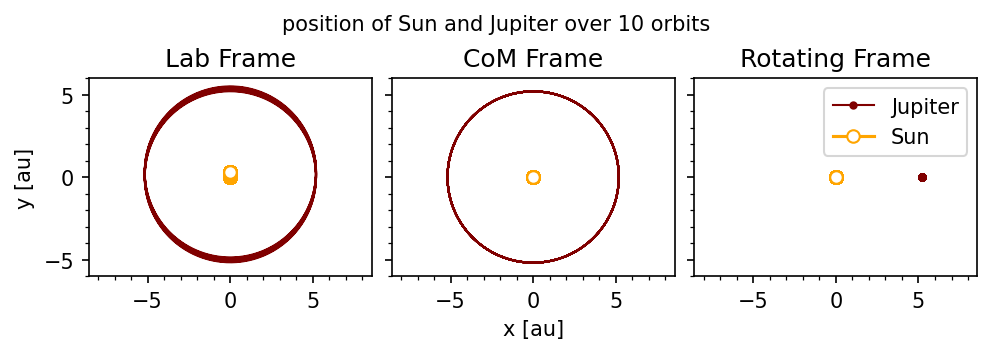

In [4]:
f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150,sharey=True)
f.set_size_inches(6.5,2.25)

#Lab Frame
a1.plot(Jupiter['x'],Jupiter['y'],lw=1,color=Jupiter['color'])
a1.plot(Sun['x'],Sun['y'],color=Sun['color'],ls=None,marker='o',mfc='white')

#CoM Frame
a2.plot(Jupiter['x_cm'],Jupiter['y_cm'],lw=1,color=Jupiter['color'])
a2.plot(Sun['x_cm'],Sun['y_cm'],color=Sun['color'],ls=None,marker='o',mfc='white')

# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
a3.plot(*J_frame,lw=1,color=Jupiter['color'],ls=None,marker='.',label="Jupiter")
a3.plot(*S_frame,color=Sun['color'],ls=None,marker='o',mfc='white',label="Sun")

for a in (a1,a2,a3):
    a.axis('equal')
    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.set_xlim(-6,6)
    a.set_ylim(-6,6)

a1.set_ylabel('y [au]')
a2.set_xlabel('x [au]')
a1.set_title('Lab Frame')
a2.set_title('CoM Frame')
a3.set_title('Rotating Frame')
a3.legend()
f.suptitle('position of Sun and Jupiter over 10 orbits',fontsize=10)
plt.show


### Questions
Based on the calculations in part I, write your answer to the following questions in the space provided.

>Q1: For this simple two-body problem, what are the expectations of the trajectories for the:  

>a) Lab frame  

The expectations of the lab frame plot show Jupiter following a larger, slightly wobbly, nearly circular orbit (shown by the dark red). The Sun follows a much smaller cicular wobble (the orange circle). Both bodies orbit their common centers of mass, the Sun's being greater than Jupiter's. So, the Sun has a much smaller orbit while Jupiter has a larger one. 

>b) Center of mass frame  

The center of mass frame is at the origin which both objects move on concentric circles about the origin. They have the same angular frequency and the total linear momentum is zero. So, the center of masses seemingly remain fixed in  unaltering circular orbits as seen in the graphs (there is no wobble in their paths). 

>c) Rotating frame  

Both bodies seemingly remain stationary in the rotating frame plot. They are at fied locations separated by their constant separation a (which is 5.2au). The time depaendent circular motion is removed because the rotating frame moves at the same angular speed as the orbital motion. So the bodies do not appear to be moving.


>Q2: If the Sun's initial velocity and position are set to 0, the position of the Sun in the Lab frame will not remain centered over time. Why does this happen? Hint: consider the behavior in the center of mass frame.   

Making the Sun initially at rest while Jupiter would still have its orbital velocity would give the system a nonzero total linear momentum. Thus, the center of mass would move with constant velocity in the lab frame. Because the bodies would be orbiting the now moving center of mass, the Sun's position in the lab frame would drift and wobble. It would not drift or wobble in the center of mass frame because it is fixed and both the bodies orbit symmetrically about it. 

## Part II: Constrained Three-Body Problem
Now that you've gotten the basic functionality down, let's move onto the 3-body problem! This time, you'll need to set the initial conditions for the Sun, Jupiter, and a test mass Satellite (Third) to reproduce the orbit criteria in each part.   
(You can use your initial conditions for the Sun and Jupiter from part I.)

Background Reading: L&dP Section 2.2




### a. Steady-State Libration
For the satellite, you'll want to find the initial conditions for a steady-state orbit about a suitable Lagrange point.   
This will depend on finding an initial position and corresponding velocity that places the Third body into a tadpole orbit.  

(This might take some experimentation.)
> Define the position of the Lagrange point you are using

> Define the initial conditions for a satellite (Third body) which has a stable tadpole orbit about a Lagrange point.

We'll want to compare distances in terms of a meaningful physical quality: the Hill Radius

> Define a function to calculate Jupiter's hill radius

In [ ]:
def r_H(): 
    """function to calculate the Hill sphere"""
    a_j = p_to_cyl(*p_j)[0]
    hill_radius = a_j * (m_j / (3 * m_s))**(1/3)
    return hill_radius 

# Define the position of the Lagrange point here
p_Lpt = (5.2*np.cos(np.pi/3), 5.2*np.sin(np.pi/3)) # this should be L4 near jupiter #dummy value, replace with your own

# Set initial conditions * HERE *
p_s = p_s
v_s = v_s
m_s = m_s

p_j = p_j
v_j = v_j
m_j = m_j

# Dummy initial conditions, replace with your own!
p_3 = p_perturb(p_Lpt, 0.01)
v_3 = set_v(p_3)
m_3 = SMALL # the third body should be a 'test mass'



# Change parameters above, not here
Sun = {'m':m_s,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':m_j, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':m_3, 'p0':p_3,'u0':v_3,'color':'violet','name':'third'}

#length of one orbit for Jupiter in code units
t_orb = T*(p_to_cyl(*p_j)[0])**(3./2.)

#setup and run a simulation
sim = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*30
err = 1e-8
dt_i = 1e-10
sim.integrate(err, dt_i, tmax)
print('Simulation Done!')
time_orb = np.array(sim.time)/t_orb # time in number of Jupiter orbits

Now we want to look at the orbit. Use the code below to:

> Plot the orbital positions over time in the CoM frame and the Rotating Frame

> Plot the radial distance from the CoM for the satellite and Jupiter over time in units of orbital times at Jupiter's location

> Indicate the bounds of Jupiter's Hill Sphere on the radial distance plot

In [ ]:
f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150)
f.set_size_inches(6.5,2.5)

# CoM Frame
a1.set_title("CoM Frame")
a1.plot(Jupiter['x_cm'],Jupiter['y_cm'],lw=1,color=Jupiter['color'])
a1.plot(Sun['x_cm'],Sun['y_cm'],color=Sun['color'],ls=None,marker='o',mfc='white')
a1.scatter(Third['x_cm'],Third['y_cm'],c=time_orb,s=0.1,cmap='inferno') # colors map to orbital times
a1.set_ylabel('y [au]')

# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
T_frame = p_rotate((Third['x_cm'],Third['y_cm']),-phij)

a2.set_title('Rotating Frame')
a2.plot(*J_frame,lw=2,color=Jupiter['color'])
a2.plot(*S_frame,color=Sun['color'],ls=None,marker='o',mfc='white')
a2.scatter(*T_frame,c=time_orb,s=0.1,cmap='inferno')

#plot the location of the Lagrange point
a2.plot(*p_Lpt,marker='x',color='black')

for a in (a1,a2):
    #a.axis('equal')
    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    a.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    a.set_xlim(min(np.amin(T_frame[0]),0),max(np.amax(T_frame[0]),p_j[0]))
    a.set_ylim(min(np.amin(T_frame[1]),0),max(np.amax(T_frame[1])*1.2,p_Lpt[1]))
    a.set_xlabel('x [au]')

# Satellite + Jupiter radial location over time
r3, phi3 = p_to_cyl(Third['x_cm'],Third['y_cm'])
a3.plot(time_orb, rj,color=Jupiter['color'])
a3.scatter(time_orb, r3,c=time_orb,s=0.1,cmap='inferno')

# plot the bounds of Jupiter's hill sphere * HERE *
r_Hill = r_H() # Calculate r_Hill * HERE *
a3.axhline(rj[0] + r_Hill, color='gray',ls='dotted')
a3.axhline(rj[0] - r_Hill, color='gray',ls='dotted')

a3.set_xlabel(r'$t \ [t_{orb}]$')

a3.set_title('Libration over Time')
a3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
a3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
a3.set_ylabel('r [au]')






### Questions

> Q1: Which Lagrange point does your satellite orbit?

*your answer here*

> Q2: What is the radial width of your tadpole orbit? How does it compare to the Hill Sphere?

*your answer here*


> Q3: What is the period of the tadpole orbit in Jupiter orbits? Do you observe any other periodicity? On what timescales? 

*your answer here*

> Q4 (Bonus): If you experiment with the initial conditions, what controls the azimuthal extent of the tadpole orbit you can achieve?

*your answer here*

### b. Horseshoe Orbit
Here you'll want to apply the same principles but this time you want to place your satellite in a horseshoe orbit.

> Define the position of the Lagrange point you are using.

> Define the initial conditions for a satellite (Third body) which has a stable horseshoe orbit about a Lagrange point.

In [ ]:
# Define the position of the Lagrange point here
p_Lpt = (0,0) #dummy value replace with your own

# Set initial conditions * HERE *
p_s = p_s # copy from before
v_s = v_s
m_s = m_s

p_j = p_j
v_j = v_j
m_j = m_j

# Dummy initial conditions, replace with your own!
p_3 = p_j
v_3 = set_v(p_3)
m_3 = m_j# the third body should be a 'test mass'

Sun = {'m':m_s,'p0':p_s,'u0':v_s,'color':'orange','name':'sun'}
Jupiter = {'m':m_j, 'p0':p_j,'u0':v_j,'color':'maroon','name':'jupiter'}
Third = {'m':m_3, 'p0':p_3,'u0':v_3,'color':'C0','name':'third'}

#length of one orbit for Jupiter in years
t_orb = 2*np.pi*(5.2**1.5)

#setup and run a simulation
tb = ThreeBody(Sun,Jupiter,Third)
tmax = t_orb*30
err = 1e-6
dt_i = 1e-8
tb.integrate(err, dt_i, tmax)
print('Simulation Done!')
time_orb = np.array(tb.time)/t_orb




Now we want to look at the orbit agan. Use the code below to:

> Plot the orbital positions over time in the CoM frame and the Rotating Frame

> Plot the radial distance from the CoM for the satellite and Jupiter over time in units of orbital times at Jupiter's location

> Include the bounds of Jupiter's Hill Sphere

In [ ]:
f,(a1,a2,a3) = plt.subplots(1,3,constrained_layout=True,dpi=150)
f.set_size_inches(6.5,2.5)

# CoM Frame
a1.set_title("CoM Frame")
a1.plot(Jupiter['x_cm'],Jupiter['y_cm'],lw=1,color=Jupiter['color'])
a1.plot(Sun['x_cm'],Sun['y_cm'],color=Sun['color'],ls=None,marker='o',mfc='white')
a1.scatter(Third['x_cm'],Third['y_cm'],c=time_orb,s=0.1,cmap='inferno') # colors map to orbital times
a1.set_ylabel('y [au]')

# In (Jupiter's) Rotating Frame w.r.t to the CoM
rj,phij = p_to_cyl(Jupiter['x_cm'],Jupiter['y_cm'])
J_frame = p_rotate((Jupiter['x_cm'],Jupiter['y_cm']),-phij)
S_frame = p_rotate((Sun['x_cm'],Sun['y_cm']),-phij)
T_frame = p_rotate((Third['x_cm'],Third['y_cm']),-phij)

a2.set_title('Rotating Frame')
a2.plot(*J_frame,lw=2,color=Jupiter['color'])
a2.plot(*S_frame,color=Sun['color'],ls=None,marker='o',mfc='white')
a2.scatter(*T_frame,c=time_orb,s=0.1,cmap='inferno')

#plot the location of the Lagrange point
a2.plot(*p_Lpt,marker='x',color='black')

for a in (a1,a2):
    #a.axis('equal')
    a.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    a.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    a.set_xlim(min(np.amin(T_frame[0]),0),max(np.amax(T_frame[0]),p_j[0]))
    a.set_ylim(min(np.amin(T_frame[1]),0),max(np.amax(T_frame[1])*1.2,p_Lpt[1]))
    a.set_xlabel('x [au]')

# Satellite + Jupiter radial location over time
r3, phi3 = p_to_cyl(Third['x_cm'],Third['y_cm'])
a3.plot(time_orb, rj,color=Jupiter['color'])
a3.scatter(time_orb, r3,c=time_orb,s=0.1,cmap='inferno')

# plot the bounds of Jupiter's hill sphere * HERE *
r_Hill = r_H() # calculate r_Hill * HERE *
a3.axhline(rj[0] + r_Hill, color='gray',ls='dotted')
a3.axhline(rj[0] - r_Hill, color='gray',ls='dotted')

a3.set_xlabel(r'$t \ [t_{orb}]$')
a3.set_title('Libration over Time')
a3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
a3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
a3.set_ylabel('r [au]')





### Questions

> Q1: What is the main difference between your initial conditions for a horseshoe orbit vs a tadpole orbit?

*your answer here*

> Q2: What is the average radial width of your horseshoe orbit? How does it compare to the Hill Sphere?

*your answer here*

> Q3: What is the period of the horseshoe orbit in Jupiter orbits? Do you observe any other periodicity? On what timescales? 

*your answer here*

> Q4 (Bonus): Show that Jacobi's constant for the satellite is, in fact, constant over the orbit. Include a plot contour of the zero-velocity curve for your horseshoe orbit on the same plot as the orbit in the rotating frame above.

*your answer here*

### c. Long-term Stability
For this part, we want to understand what determines the long-term stability for an orbit. So far we've run both of the above cases for 10-30 orbits, but certain dynamical conditions can be susceptible to *secular* instability: instabilities that take many dynamical timescales to accrue. Here you will use the numerical tools you have so far to demonstrate which ones.

In this next part, you will set up your own numerical experiments (you can copy/paste/modify the procedures and plots in the above parts below) to investigate long-term stability.

This time you'll want to run your simulations for at least a few 100 orbits (these will take a longer time, for ex: if it took one second to run 30 orbits, it will take at least 10 seconds to run 300 orbits) 

This portion is more open-ended but you must include code to run and show the results for at least 3 simulations:

> 1. a simulation for a tadpole orbit for at least 300 orbits

> 2. a simulation for a horseshoe orbit for at least 300 orbits

> 3. a simulation for the horseshoe orbit initial conditions (perturbed by a choice of $dr$ or $d\phi$) for at least 300 orbits. 


In [ ]:
# * HERE *

In [ ]:
# * HERE *

### Questions

> Q1. Describe the main results for each of the three simulations in terms of orbital behavior, characteristics, and evolution over time.

> Q2. Based on your calculations, what orbital configurations are the most favorable for long term stability? Defend your conclusion based on the results you have shown. 

# Project Rubric
Learning Objectives:
+ Use a simulation to investigate the physical principles of the three-body problem (L & dP 2.2)
+ Apply physics principles to the set up of initial conditions in the simulations. 
+ Conduct numerical experiments: change the parameters of a simulation (dependent variables) and analyse their effect on the results (independent variables)
+ Use plots to reason about observed simulation behavior and apply physical principles to the interpretation of results
+ Construct a conceptual picture of orbital stability based on physical principles from the text and numerical results

Projects will be in the range for the following letter grades according to the criteria below: 

**A**: all parts (including responses to the required questions) are fully completed, most major objectives fully achieved and demonstrated

**B**: all parts (including responses to the required questions) are mostly completed, most major objectives at least partially acheived and demonstrated

**C**: part I, part II a and b (including responses to the required questions) are completed w/ major objectives partially achieved and demonstrated. part II c has been attempted so far as to demonstrate some of the major objectives

## Submission format
Your submitted notebook should include all the code and answers to questions that you plan on submitting.

All code to generate your results should be present and run independently from start to finish (i.e. if you click restart kernel, you should be able run each cell in order of appearance and reproduce the cell outputs) 

Prior to submission, save the file with all cells executed and all plots generated.

